In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad

from dataclasses import dataclass

from bayes.distribution import GaussianMixture, gmm_log_p
from bayes.posterior import FlowBasedPosterior, PRNGKeyManager
from bayes.map import find_map_with_overparameterization

from sinterp.interpolants import get_interp
from functools import partial
import flax.linen as nn
import optax
from jax.scipy.stats import multivariate_normal
from jax.scipy.special import logsumexp
import abc
from dataclasses import dataclass
# jax.config.update('jax_disable_jit', True)
jax.config.update("jax_debug_nans", True)

# 1. Define the Ground-Truth GMM
N_COMPONENTS = 2
DATA_DIM = 2

gmm_true_weights = jnp.array([0.7, 0.3])
gmm_true_means = jnp.array([[-2., -2.], [2., 2.]]) + 1

# Use two distinct covariance matrices for a more interesting target
gmm_true_covs = jnp.array([
    # Component 1: Strong positive correlation (elongated along y=x)
    [[1.0, 0.8], 
     [0.8, 1.0]],
    # Component 2: Strong negative correlation (elongated along y=-x)
    [[1.0, -0.8], 
     [-0.8, 1.0]]
])

unit_covs = jnp.array([
    [[1.0, 0.0], 
     [0.0, 1.0]],
    [[1.0, 0.0], 
     [0.0, 1.0]]
])

target_gmm = GaussianMixture(gmm_true_weights, gmm_true_means, gmm_true_covs)
# 2. Define Parameter Space and Likelihood Function

# The number of parameters for a lower-triangular matrix of size DATA_DIM x DATA_DIM
CHOLESKY_PARAMS_PER_COMP = DATA_DIM * (DATA_DIM + 1) // 2

# The total number of parameters we need to learn for the GMM
PARAM_DIM = (N_COMPONENTS * DATA_DIM) + \
            (N_COMPONENTS * CHOLESKY_PARAMS_PER_COMP) + \
            N_COMPONENTS
# (means) + (cholesky factors) + (weights)

@dataclass
class Theta:
    """A structured container for GMM parameters."""
    means: jnp.ndarray
    covs: jnp.ndarray
    log_weights: jnp.ndarray

def vec_to_theta(h: jnp.ndarray) -> Theta:
    """
    Converts a flat vector `h` into a structured Theta object, ensuring that
    the covariance matrices are valid (symmetric and positive semi-definite).
    """
    # 1. Slice the flat vector `h` into its constituent parts.
    c = 0
    means = h[c:c + N_COMPONENTS * DATA_DIM].reshape(N_COMPONENTS, DATA_DIM)
    c += N_COMPONENTS * DATA_DIM
    
    cholesky_params = h[c:c + N_COMPONENTS * CHOLESKY_PARAMS_PER_COMP].reshape(N_COMPONENTS, -1)
    c += N_COMPONENTS * CHOLESKY_PARAMS_PER_COMP
    
    weight_params = h[c:]

    # 2. Construct valid SPD covariance matrices using Cholesky decomposition.
    # We use vmap to apply this transformation to each component's parameters.
    def build_spd_matrix(params):
        L = jnp.zeros((DATA_DIM, DATA_DIM))
        tril_indices = jnp.tril_indices(DATA_DIM)
        L = L.at[tril_indices].set(params)

        # --- NEW STABILIZING CODE ---
        # Get the raw diagonal parameters that came from the input vector 'h'
        diag_params = jnp.diag(L)
        
        # Clamp the inputs to jnp.exp using tanh.
        # This is the key fix: it prevents the ODE solver from feeding
        # a value into `exp` that would cause it to overflow to `inf`.
        # A scaling factor of 15.0 means the diagonal of L will be bounded
        # between exp(-15) (~3e-7) and exp(15) (~3e6), a very wide but safe range.
        STABILITY_FACTOR = 15.0
        safe_diag_values = jnp.exp(STABILITY_FACTOR * jnp.tanh(diag_params / STABILITY_FACTOR))
        
        # Set the now-safe diagonal values
        L = L.at[jnp.diag_indices(DATA_DIM)].set(safe_diag_values)
        # --- END NEW CODE ---

        # The covariance matrix is L @ L.T
        # The jitter is still a good practice to prevent singularity if diagonals get too small.
        return (L @ L.T) + jnp.eye(DATA_DIM) * 1e-6

    covs = vmap(build_spd_matrix)(cholesky_params)

    # 3. Ensure weights are valid (sum to 1) using log_softmax.
    log_weights = jax.nn.log_softmax(weight_params)
    
    return Theta(means, covs, log_weights)

def gmm_log_p(means, covs, log_weights, y):
    """Calculates log p(y | theta) for a single data point y."""
    log_probs_all_components = multivariate_normal.logpdf(y, means, covs)
    weighted_log_probs = log_probs_all_components + log_weights
    return logsumexp(weighted_log_probs)

def build_total_log_likelihood_and_grad(observations):
    """
    Builds the function that computes the gradient of the log-likelihood
    with respect to the FLATTENED parameter vector `h`.
    """
    y_data = jnp.array(observations)

    # 1. Define the total log-likelihood in terms of the flat vector `h`.
    def total_log_likelihood(h, y_data_batch):
        """
        p(y_data | h) aka p(x | \theta)
        Calculates the total log-likelihood for a batch of data given
        the flattened parameter vector `h`.
        """
        # Convert the flat vector `h` into a structured Theta object INSIDE the function.
        theta = vec_to_theta(h)

        # Define the log-likelihood for a single data point.
        def single_log_p(y):
            return gmm_log_p(theta.means, unit_covs, theta.log_weights, y)

        # Map over the batch of data and sum the log-likelihoods.
        return jnp.sum(vmap(single_log_p)(y_data_batch))

    # 2. Differentiate with respect to the first argument, `h`.
    # The resulting function has the signature grad_fn(h, y_data), which is
    # exactly what the FlowBasedPosterior expects.
    total_log_likelihood_grad_fn = grad(total_log_likelihood, argnums=0)

    # 3. Return the correctly-signed gradient function and the full dataset.
    return total_log_likelihood_grad_fn, y_data

# 3. Initialize the Posterior Model
key_manager = PRNGKeyManager(seed=1)
interpolator = get_interp('OneSidedLinear')

# Initialize the posterior over the PARAMETER space
posterior = FlowBasedPosterior(
    build_total_log_likelihood_and_grad=build_total_log_likelihood_and_grad,
    dim=PARAM_DIM,  # The dimension is the number of GMM parameters
    key_manager=key_manager,
    interpolator=interpolator,
    distillation_threshold=100
)

# 4. Simulate and add observations to the model
print("--- Generating and Adding Observations ---")
num_observations = 500
observations = target_gmm.sample(key_manager.split(), shape=(num_observations,))
for obs in observations:
    posterior.add_observation(obs) # This will trigger _distill()

# 5. Find the MAP estimate of the parameters
# The 'x' being found here is the flattened parameter vector 'h'
h_map, final_log_prob = find_map_with_overparameterization(
    posterior=posterior,
    key_manager=key_manager,
    num_steps=3000, # Increased steps for this harder problem
    learning_rate=1e-4
)

# 6. Verify the result against the true GMM parameters
theta_map = vec_to_theta(h_map)

print("\n--- Verification ---")
print(f"Found MAP estimate for parameters (h_map): {h_map}")
print("\n--- Comparing True vs. Found GMM Parameters ---")

print("\nMEANS:")
print("True:\n", gmm_true_means)
print("Found:\n", theta_map.means)

print("\nCOVARIANCE MATRICES:")
print("True:\n", gmm_true_covs)
print("Found:\n", theta_map.covs)

print("\nWEIGHTS:")
print("True:\n", gmm_true_weights)
print("Found:\n", jnp.exp(theta_map.log_weights))

Initialized with a one-sided framework and OneSidedLinear interpolator.
--- Generating and Adding Observations ---

--- Distilling Likelihood (Unified Stochastic Score-Matching) ---
Distillation Step 0, Unified Loss: 999898.0000
Distillation Step 500, Unified Loss: 1151623.5000
Distillation complete.
---

--- Distilling Likelihood (Unified Stochastic Score-Matching) ---
Distillation Step 0, Unified Loss: 881165.7500
Distillation Step 500, Unified Loss: 946663.5000
Distillation complete.
---

--- Distilling Likelihood (Unified Stochastic Score-Matching) ---
Distillation Step 0, Unified Loss: 970648.3125
Distillation Step 500, Unified Loss: 721541.3750
Distillation complete.
---

--- Distilling Likelihood (Unified Stochastic Score-Matching) ---
Distillation Step 0, Unified Loss: 717585.7500
Distillation Step 500, Unified Loss: 725006.3125
Distillation complete.
---

--- Distilling Likelihood (Unified Stochastic Score-Matching) ---
Distillation Step 0, Unified Loss: 1128521.1250
Distillat

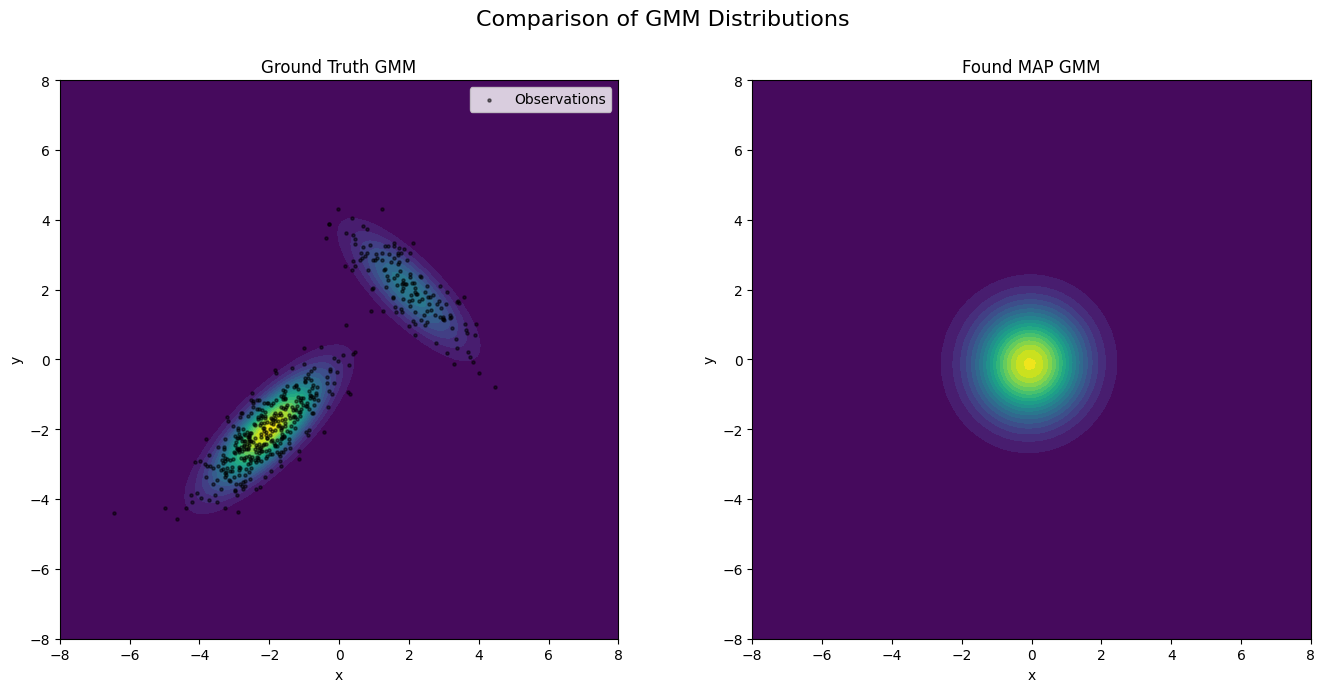

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gmm_contour(ax, means, covs, weights, title, data=None):
    """
    Generates a 2D contour plot of a GMM's probability density.
    
    Args:
        ax: Matplotlib axes object to plot on.
        means: Component means (K, D).
        covs: Component covariance matrices (K, D, D).
        weights: Component weights (K,).
        title: Plot title.
        data: Optional raw data points to scatter on the plot.
    """
    # 1. Create a grid of points to evaluate the GMM on.
    x = np.linspace(-8, 8, 100)
    y = np.linspace(-8, 8, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = jnp.array(np.stack([X.ravel(), Y.ravel()], axis=-1))

    # 2. Vectorize the gmm_log_p function to evaluate all grid points at once.
    # We map over the last argument 'y' (the data point).
    batched_log_p = vmap(gmm_log_p, in_axes=(None, None, None, 0))
    
    # 3. Calculate the log probability for each point on the grid.
    log_weights = jnp.log(weights)
    log_probs = batched_log_p(means, covs, log_weights, grid_points)
    
    # 4. Convert to probabilities and reshape for contour plotting.
    probs = jnp.exp(log_probs)
    Z = probs.reshape(X.shape)
    
    # 5. Create the contour plot.
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal', adjustable='box')

    # 6. (Optional) Overlay the raw data points used for fitting.
    if data is not None:
        ax.scatter(data[:, 0], data[:, 1], c='black', s=5, alpha=0.5, label='Observations')
        ax.legend()


# Create the figure and axes for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the Ground Truth GMM on the left subplot
plot_gmm_contour(
    ax=axes[0],
    means=gmm_true_means,
    covs=gmm_true_covs,
    weights=gmm_true_weights,
    title="Ground Truth GMM",
    data=observations
)

# Plot the Found MAP GMM on the right subplot
# Also, show the observation points that were used to find the fit.
plot_gmm_contour(
    ax=axes[1],
    means=theta_map.means,
    covs=theta_map.covs,
    weights=jnp.exp(theta_map.log_weights),
    title="Found MAP GMM",

)

plt.suptitle("Comparison of GMM Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

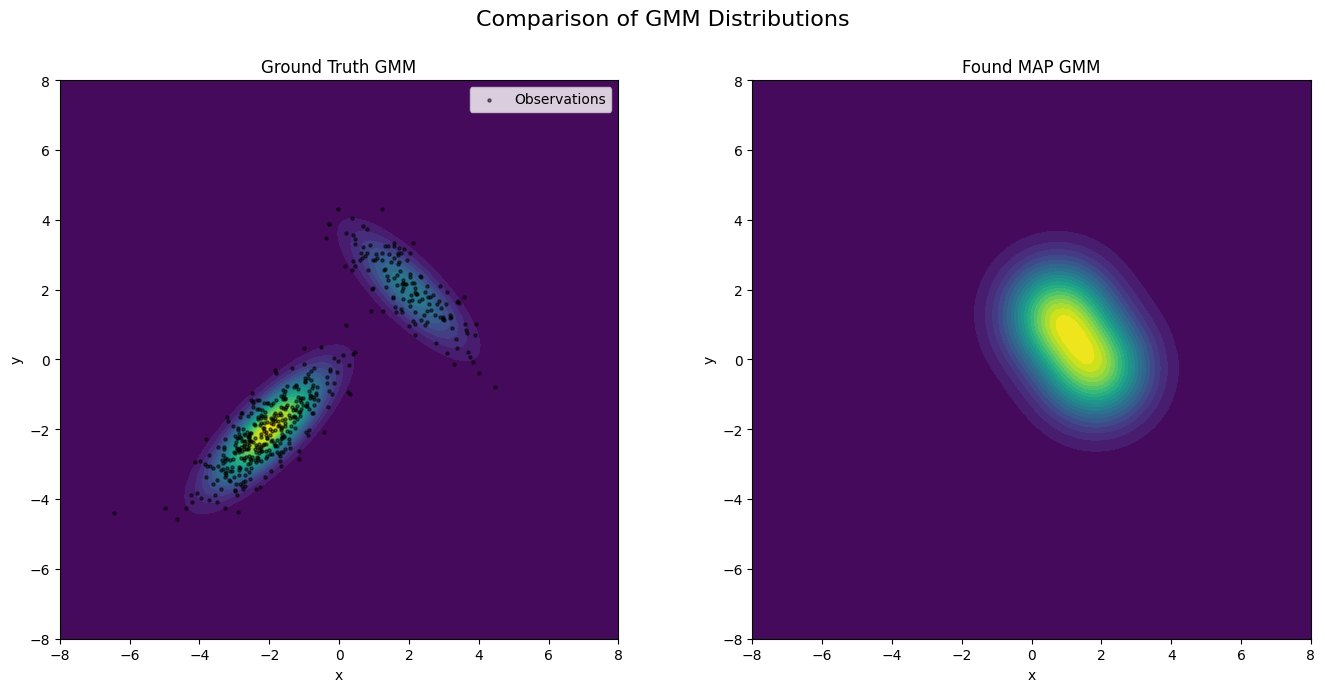

In [32]:
h = posterior.sample(key_manager.split(), (1, ))
theta = vec_to_theta(h[0])

# Create the figure and axes for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the Ground Truth GMM on the left subplot
plot_gmm_contour(
    ax=axes[0],
    means=gmm_true_means,
    covs=gmm_true_covs,
    weights=gmm_true_weights,
    title="Ground Truth GMM",
    data=observations
)

# Plot the Found MAP GMM on the right subplot
# Also, show the observation points that were used to find the fit.
plot_gmm_contour(
    ax=axes[1],
    means=theta.means,
    covs=unit_covs,
    weights=jnp.exp(theta.log_weights),
    title="Found MAP GMM",

)

plt.suptitle("Comparison of GMM Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()